# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')

df.head()


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

# Data preparation

In [20]:
# Checking for percentage of missing values in the dataset
missing_values = df.isnull().sum() / len(df) * 100

# Dropping columns with more than 80% missing values
df.drop(columns = missing_values[missing_values > 80].index, inplace = True)

#Filling missing values with unknown beetween 10% and 80% misisng values
columns_to_fill = missing_values[(missing_values > 10) & (missing_values <= 80)].index
df[columns_to_fill] = df[columns_to_fill].fillna('unknown')

#Filling missing values with mode for the columns with less than 10% missing values
columns_to_fill_under10 = missing_values[missing_values <= 10].index
df[columns_to_fill_under10] = df[columns_to_fill_under10].fillna(df[columns_to_fill_under10].mode().iloc[0])

# Dropping duplicates
df.drop_duplicates(inplace=True)


In [ ]:
#Checking how many unique values are in each column
categorical_columns = df.select_dtypes(include=['object']).columns
unique_values = df[categorical_columns].nunique()

#Label Encoding for columns with 2 or less unique values
le = LabelEncoder()
for col in unique_values[unique_values <= 2].index:    
    df[col] = le.fit_transform(df[col])

# One Hot Encoding for columns with more than 2 unique values
ohe = OneHotEncoder(sparse_output=False)
for col in unique_values[unique_values > 2].index:
    encoded = ohe.fit_transform(df[[col]])
    endoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([col]), index=df.index)
    df = pd.concat([df, endoded_df], axis=1)
    df.drop(columns=[col], inplace=True)

# Model 1: Logistic regression

In [22]:
# importing the necessary libraries for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting the data into features and target variable
X = df.drop(columns=['class'])
y = df['class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

log_reg = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
}

# random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, n_iter=10, cv=5, scoring='recall', random_state=42)
# random_search.fit(X_train, y_train)

# print("Best parameters for Logistic Regression: ", random_search.best_params_)
# to save computaion time, I will use the best parameters from the previous run
#Best parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

In [23]:
log_reg = LogisticRegression(max_iter=100, random_state=42, C=0.01, penalty='l2', solver='lbfgs')

log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print(classification_report(y_test, y_pred_log_reg))
print("Accuracy: ", accuracy_score(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      5365
           1       0.85      0.83      0.84      6820

    accuracy                           0.82     12185
   macro avg       0.82      0.82      0.82     12185
weighted avg       0.82      0.82      0.82     12185

Accuracy:  0.8234714813295035


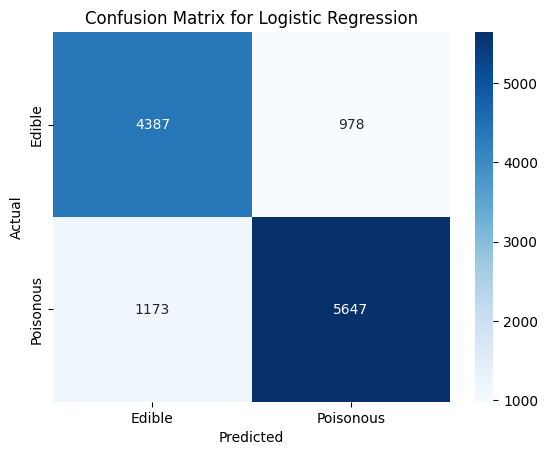

In [24]:
#Confusion matrix for logistic regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=["Edible", 'Poisonous'])
plt.yticks(ticks=[0.5, 1.5], labels=["Edible", 'Poisonous'])
plt.show()

# Discussion of performance metric

F1 score is a good metric to use for this dataset, as it takes into account both precision and recall. This is important because we want to minimize false positives (predicting a mushroom is edible when it is actually poisonous) and false negatives (predicting a mushroom is poisonous when it is actually edible). The F1 score provides a balance between these two metrics, making it a good choice for this classification problem.

# Model 2: Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3,scoring ='recall', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_rf = grid_search.best_estimator_
# y_pred_best_rf = best_rf.predict(X_test)
# print("Best Random Forest Hyperparameters:", grid_search.best_params_)

In [26]:
# to save computaion time, I will use the best parameters from the previous run
# Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best_hyperparameters = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
rf = RandomForestClassifier(**best_hyperparameters)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5365
           1       1.00      1.00      1.00      6820

    accuracy                           1.00     12185
   macro avg       1.00      1.00      1.00     12185
weighted avg       1.00      1.00      1.00     12185

Random Forest Accuracy:  1.0


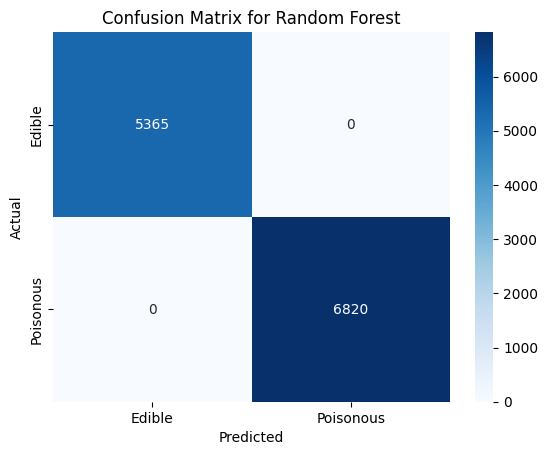

In [28]:
#Confusion matrix for random forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0.5, 1.5], labels=["Edible", 'Poisonous'])
plt.yticks(ticks=[0.5, 1.5], labels=["Edible", 'Poisonous'])
plt.show()

# Discussion

The random forest model's perfect performance raises concerns about its strength and ability to handle new data. It may have memorized the training set rather than learning generalizable patterns. In contrast, the logistic regression model's performance suggests it has learned meaningful relationships in the data, making it a more reliable choice for practical applications.